We put the parameters to our model in an extra class for better readability.
These values were fitted to the experimental data of Hodgkin and Huxley.


In [1]:
# CONSTANTS

class HHParameters:
    def __init__(self):
        self.C_m = 1.0     # membrane capacitance, in uF/cm^2
        self.g_Na = 120.0  # maximum conductances, in mS/cm^2
        self.g_K = 36.0
        self.g_L = 0.3
        self.U_Na = 50.0   # Nernst reversal potentials, in mV
        self.U_K = -77.0
        self.U_L = -54.387
        self.U_pot = -65.0 # , in mV

params = HHParameters()

We collect the static methods alpha and beta in a class that doesnt need to be instantiated.

In [2]:

import numpy as np
import matplotlib.pyplot as plt

class HHGatingVariables:
    @staticmethod
    def alpha_n(U):
        return -0.01 * (55 + U) / (np.exp(-(55 + U) / 10) - 1)
    
    @staticmethod
    def beta_n(U):
        return 0.125 * np.exp(-(65 + U) / 80)
    
    @staticmethod
    def alpha_m(U):
        return -0.1 * (40 + U) / (np.exp(-(40 + U) / 10) - 1)
    
    @staticmethod
    def beta_m(U):
        return 4.0 * np.exp(-(65 + U) / 18)
    
    @staticmethod
    def alpha_h(U):
        return 0.07 * np.exp(-(65 + U) / 20)
    
    @staticmethod
    def beta_h(U):
        return 1 / (np.exp(-(35 + U) / 10) + 1)

In [3]:
# contains n, m, h and U values and the math to compute the derivatives
class HHModel:
    def __init__(self, parameters):
        self.params = parameters
        self.U = self.params.U_pot  # initial membrane potential

        # we start with the gating variables in their equilibrium state:
        self.n = self._n_inf(self.U) 
        self.m = self._m_inf(self.U)
        self.h = self._h_inf(self.U)

    @staticmethod
    def _n_inf(U):
        return HHGatingVariables.alpha_n(U) / (HHGatingVariables.alpha_n(U) + HHGatingVariables.beta_n(U))
    
    @staticmethod
    def _m_inf(U):
        return HHGatingVariables.alpha_m(U) / (HHGatingVariables.alpha_m(U) + HHGatingVariables.beta_m(U))
    
    @staticmethod
    def _h_inf(U):
        return HHGatingVariables.alpha_h(U) / (HHGatingVariables.alpha_h(U) + HHGatingVariables.beta_h(U))

    def compute_derivatives(self, U, n, m, h, I_ext):
        dn = HHGatingVariables.alpha_n(U) * (1 - n) - HHGatingVariables.beta_n(U) * n
        dm = HHGatingVariables.alpha_m(U) * (1 - m) - HHGatingVariables.beta_m(U) * m
        dh = HHGatingVariables.alpha_h(U) * (1 - h) - HHGatingVariables.beta_h(U) * h
        
        I_Na = self.params.g_Na * m**3 * h * (U - self.params.U_Na)
        I_K = self.params.g_K * n**4 * (U - self.params.U_K)
        I_L = self.params.g_L * (U - self.params.U_L)
        
        dU = (I_ext - I_Na - I_K - I_L) / self.params.C_m
        
        return np.array([dU, dn, dm, dh])
    
hh_model = HHModel(params)


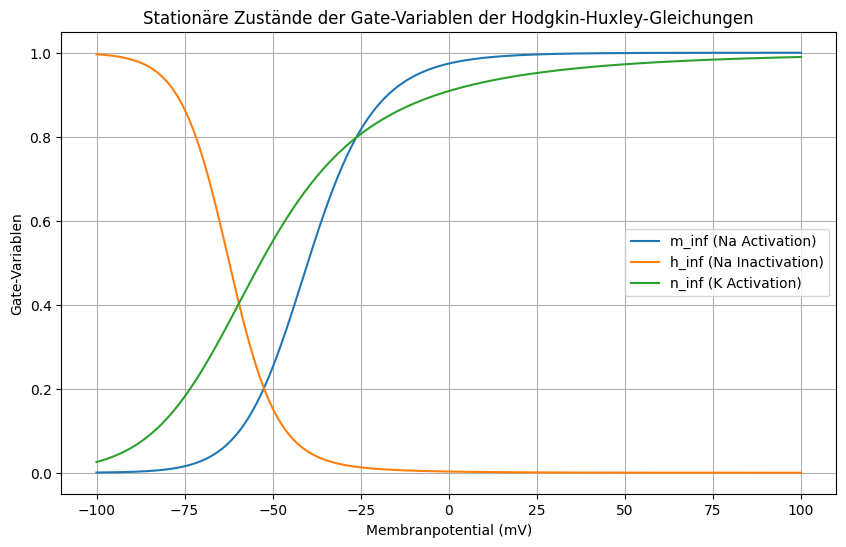

In [4]:
# plots the equilibrium curves of the gating variables against the membrane potential

# Spannungsbereich
U_range = np.linspace(-100, 100, 500)

# Berechnung der stationären Zustände
n_inf = HHModel._n_inf(U_range)
m_inf = HHModel._m_inf(U_range)
h_inf = HHModel._h_inf(U_range)

# Plotten der stationären Zustände der Gate-Variablen gegen Spannung
plt.figure(figsize=(10, 6))
plt.plot(U_range, m_inf, label='m_inf (Na Activation)')
plt.plot(U_range, h_inf, label='h_inf (Na Inactivation)')
plt.plot(U_range, n_inf, label='n_inf (K Activation)')

plt.xlabel('Membranpotential (mV)')
plt.ylabel('Gate-Variablen')
plt.title('Stationäre Zustände der Gate-Variablen der Hodgkin-Huxley-Gleichungen')
plt.legend()
plt.grid(True)
plt.show()


Sinnvolle Anfangszustände sind also zum Beispiel gegeben durch die Equilibrumszustände bei $$U = V_{pot} = -65 mV$$


In [5]:
# returns the external current for the simulated neuron in nA
def I_ext(t):
    return 5


In [6]:
# abstract class for our 3 simulation classes: 
class HHSimulation:
    def __init__(self, hh_model, time, dt, I_ext: callable):
        self.hh_model = hh_model
        self.time = time
        self.dt = dt
        self.I_ext = I_ext 
        self.t_values = np.arange(0, time, dt)
        self.U_values = np.zeros(len(self.t_values))
        self.n_values = np.zeros(len(self.t_values))
        self.m_values = np.zeros(len(self.t_values))
        self.h_values = np.zeros(len(self.t_values))

    # abstract method that will be implemented by the subclasses
    def run(self):
        raise NotImplementedError("subclass has to implement this method")

    # we will reuse this for the different simulations
    @staticmethod
    def plot_results(t, U, n, m, h):
        # Plot der zeitlichen Entwicklung des Membranpotentials und der Gate-Variablen
        plt.figure(figsize=(12, 8))

        # Membranpotential
        plt.subplot(2, 1, 1)
        plt.plot(t, U, label='Membranpotential (U)')
        plt.ylabel('Membranpotential (mV)')
        plt.legend()

        # Gate-Variablen
        plt.subplot(2, 1, 2)
        plt.plot(t, n, label='n')
        plt.plot(t, m, label='m')
        plt.plot(t, h, label='h')
        plt.xlabel('Zeit (ms)')
        plt.ylabel('Gate-Variablen')
        plt.legend()

        plt.show()

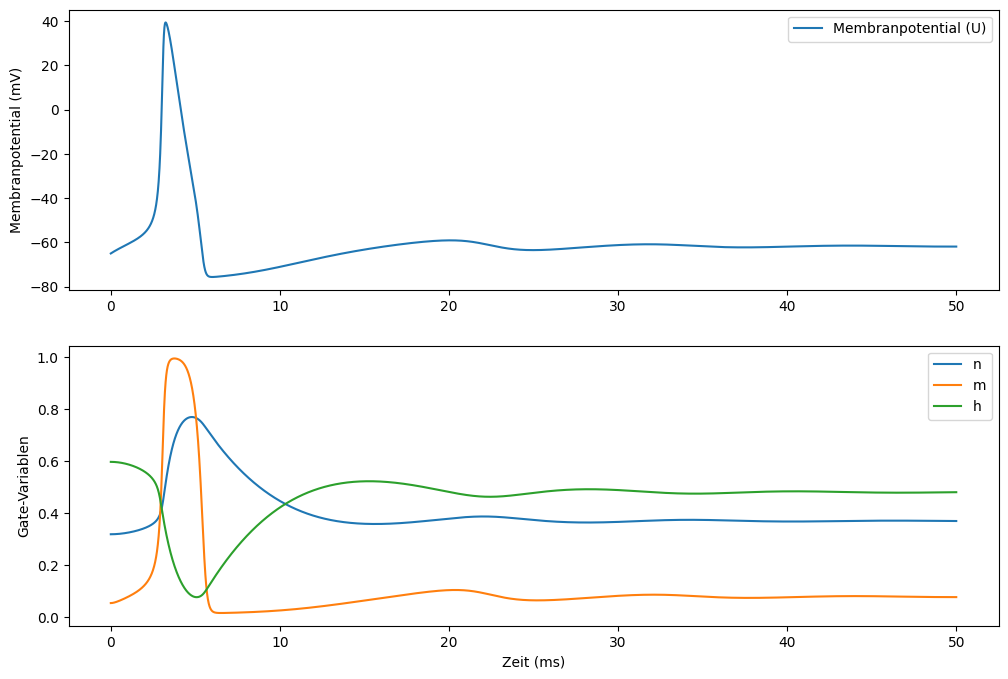

In [7]:
class HHSimulationEuler(HHSimulation):
    def run(self):
        U = self.hh_model.U
        n = self.hh_model.n
        m = self.hh_model.m
        h = self.hh_model.h

        for i, t in enumerate(self.t_values):
            self.U_values[i] = U
            self.n_values[i] = n
            self.m_values[i] = m
            self.h_values[i] = h

            y = [U,n,m,h]
            I_ext = self.I_ext(t)

            dy = self.hh_model.compute_derivatives(*y, I_ext)

            U, n, m, h = y + dy * self.dt

        return self.t_values, self.U_values, self.n_values, self.m_values, self.h_values

euler_sim = HHSimulationEuler(hh_model, time=50, dt=0.01, I_ext=I_ext)
t, U, n, m, h = euler_sim.run()

HHSimulation.plot_results(t, U, n, m, h)

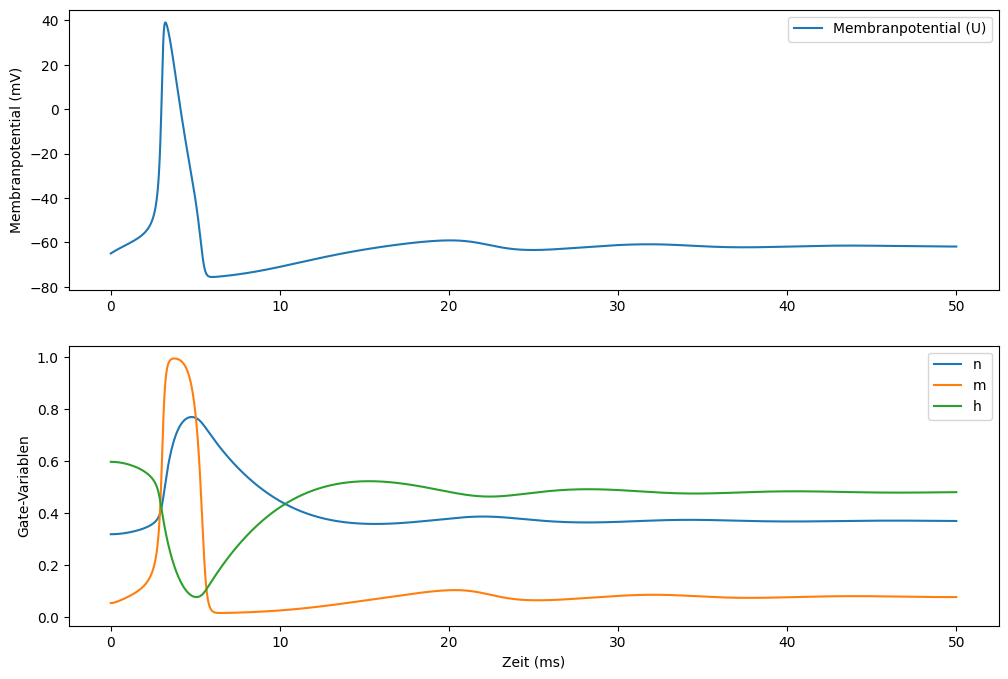

In [8]:
# runs a simulation using the classical Runge-Kutta method to solve the ODE
class HHSimulationClassicalRungeKutta(HHSimulation):

    def run(self):
        U = self.hh_model.U
        n = self.hh_model.n
        m = self.hh_model.m
        h = self.hh_model.h

        for i, t in enumerate(self.t_values):
            self.U_values[i] = U
            self.n_values[i] = n
            self.m_values[i] = m
            self.h_values[i] = h

            y = [U,n,m,h]
            I_ext = self.I_ext(t)

            k1 = self.hh_model.compute_derivatives(*y, I_ext)
            k2 = self.hh_model.compute_derivatives(*(y + k1*self.dt/2), I_ext)
            k3 = self.hh_model.compute_derivatives(*(y + k2*self.dt/2), I_ext)
            k4 = self.hh_model.compute_derivatives(*(y + k3*self.dt), I_ext)

            U, n, m, h = y + (k1 + 2*k2 + 2*k3 + k4)*self.dt/6

        return self.t_values, self.U_values, self.n_values, self.m_values, self.h_values

rk_sim = HHSimulationClassicalRungeKutta(hh_model, time=50, dt=0.01, I_ext=I_ext)
t, U, n, m, h = rk_sim.run()

HHSimulation.plot_results(t, U, n, m, h)

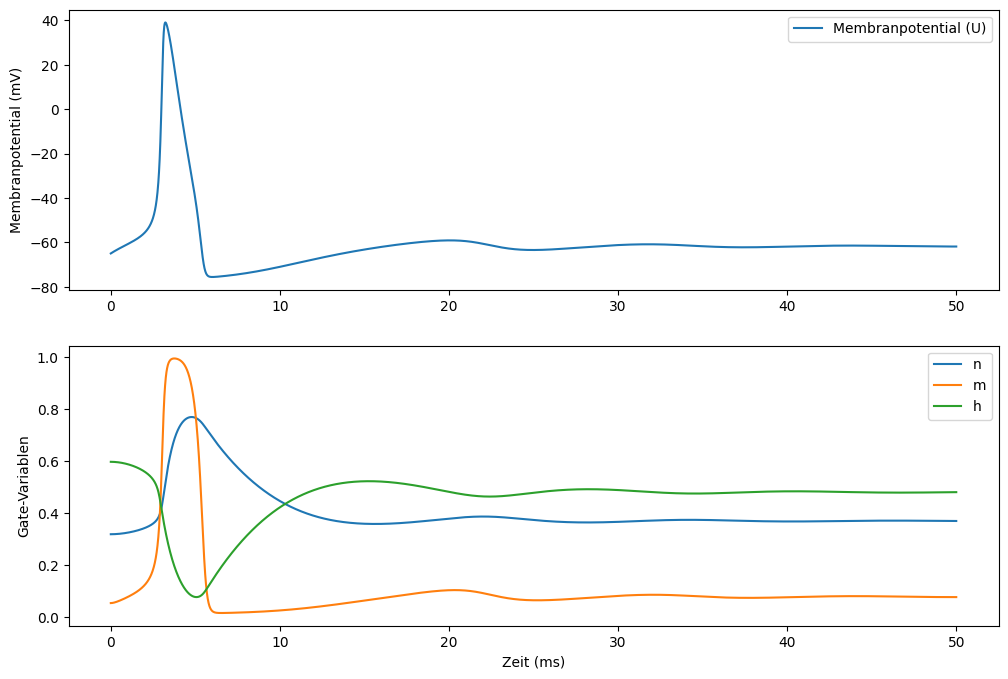

In [9]:
from scipy.integrate import odeint

# runs a simulation using the odeint method to solve the ODE
class HHSimulationOdeint(HHSimulation):

    def run(self):
        y0 = [self.hh_model.U, self.hh_model.n, self.hh_model.m, self.hh_model.h]
        y_list = odeint(self.compute_derivatives_wrapper, y0, self.t_values)
        return self.t_values, y_list[:, 0], y_list[:, 1], y_list[:, 2], y_list[:, 3]

    # wrapper to match odeint´s required call signature, because compute_derivatives does not need t as input
    def compute_derivatives_wrapper(self, y, t):
        return self.hh_model.compute_derivatives(*y, self.I_ext(t))

odeint_sim = HHSimulationOdeint(hh_model, time=50, dt=0.01, I_ext=I_ext)
t, U, n, m, h = odeint_sim.run()

HHSimulation.plot_results(t, U, n, m, h)

C:\Users\thoms\AppData\Local\Temp\ipykernel_25100\487770266.py:7: RuntimeWarning: overflow encountered in exp
  return -0.01 * (55 + U) / (np.exp(-(55 + U) / 10) - 1)
C:\Users\thoms\AppData\Local\Temp\ipykernel_25100\487770266.py:11: RuntimeWarning: overflow encountered in exp
  return 0.125 * np.exp(-(65 + U) / 80)
C:\Users\thoms\AppData\Local\Temp\ipykernel_25100\487770266.py:15: RuntimeWarning: overflow encountered in exp
  return -0.1 * (40 + U) / (np.exp(-(40 + U) / 10) - 1)
C:\Users\thoms\AppData\Local\Temp\ipykernel_25100\487770266.py:19: RuntimeWarning: overflow encountered in exp
  return 4.0 * np.exp(-(65 + U) / 18)
C:\Users\thoms\AppData\Local\Temp\ipykernel_25100\487770266.py:23: RuntimeWarning: overflow encountered in exp
  return 0.07 * np.exp(-(65 + U) / 20)
C:\Users\thoms\AppData\Local\Temp\ipykernel_25100\487770266.py:27: RuntimeWarning: overflow encountered in exp
  return 1 / (np.exp(-(35 + U) / 10) + 1)
C:\Users\thoms\AppData\Local\Temp\ipykernel_25100\2506686653.py

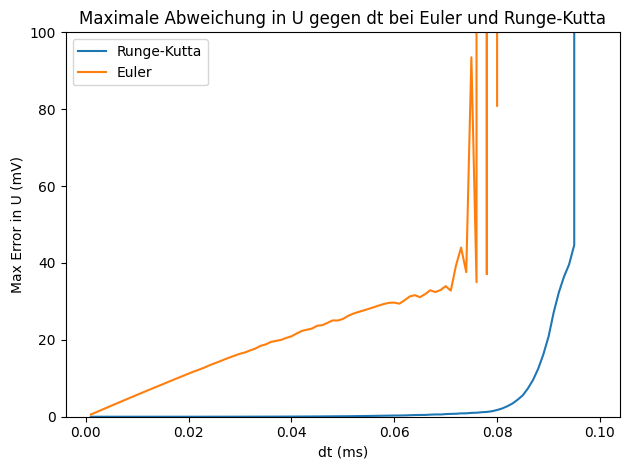

smallest dt value where error with Euler is greater than 5:  0.009000000000000001
smallest dt value where error with Runge-Kutta is greater than 5:  0.085


In [10]:

# plot maximum difference against dt when using Runge-Kutta
dt_list = np.arange(0.001, 0.1, 0.001)
time_period = 30
errors_rk = np.zeros(len(dt_list))
errors_euler = np.zeros(len(dt_list))

for i, dt in enumerate(dt_list):
    try:
        _, U_euler, _, _, _ = HHSimulationEuler(hh_model, time_period, dt, I_ext).run()
        _, U_rk, _, _, _ = HHSimulationClassicalRungeKutta(hh_model, time_period, dt, I_ext).run()
        _, U_odeint, _, _, _ = HHSimulationOdeint(hh_model, time_period, dt, I_ext).run()

        max_difference_euler = max(np.abs(U_euler - U_odeint))
        max_difference_rk = max(np.abs(U_rk - U_odeint))

        errors_euler[i] = max_difference_euler
        errors_rk[i] = max_difference_rk

    except RuntimeWarning:
        errors_rk[i] = np.inf
        break

plt.plot(dt_list, errors_rk, label="Runge-Kutta")
plt.plot(dt_list, errors_euler, label="Euler")

plt.title("Maximale Abweichung in U gegen dt bei Euler und Runge-Kutta")
plt.xlabel("dt (ms)")
plt.ylabel("Max Error in U (mV)")
ax = plt.gca()
ax.set_ylim(0, 100) # set y-axis limit because errors go up to 2**128 quickly and the plot becomes unreadable
plt.legend()
plt.tight_layout()
plt.show()

print("smallest dt value where error with Euler is greater than 5: ", dt_list[np.where(errors_euler > 5)[0][0]])
print("smallest dt value where error with Runge-Kutta is greater than 5: ", dt_list[np.where(errors_rk > 5)[0][0]])

In [11]:
# comparing the time efficiency of the 3 different methods: 

import time
import inspect

def time_func(func, *args):
    start = time.perf_counter()
    func(*args)
    end = time.perf_counter ()
    return end - start


dt = 0.01

time_euler = time_func(HHSimulationEuler(hh_model, time_period, dt, I_ext).run)   
time_rk = time_func(HHSimulationClassicalRungeKutta(hh_model, time_period, dt, I_ext).run)
time_odeint = time_func(HHSimulationOdeint(hh_model, time_period, dt, I_ext).run)

print("Simulation Parameters: ", {"time_period": time_period, "dt": dt, "I_ext": inspect.getsource(I_ext)})
print(f"Euler: {time_euler} seconds")
print(f"Runge-Kutta: {time_rk} seconds")
print(f"odeint: {time_odeint} seconds")

Simulation Parameters:  {'time_period': 30, 'dt': 0.01, 'I_ext': 'def I_ext(t):\n    return 5\n'}
Euler: 0.06894010002724826 seconds
Runge-Kutta: 0.2519217999652028 seconds
odeint: 0.015719400020316243 seconds


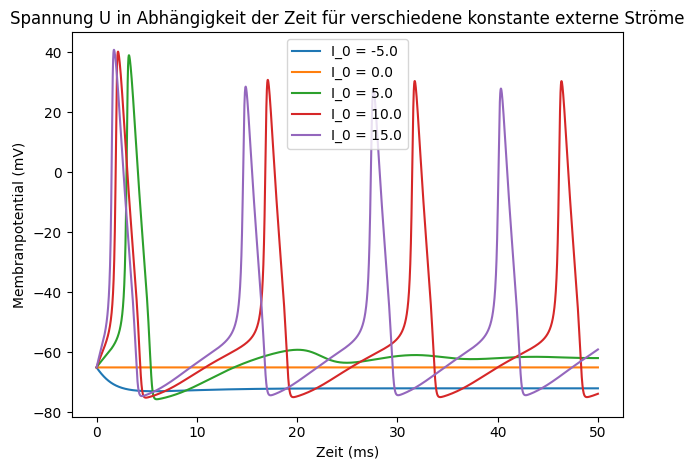

In [12]:
# Visualising U for different constant external currents

I_0_list = np.arange(-5, 15.1, 5)

for I_0 in I_0_list:
    t, U, _, _, _ = HHSimulationClassicalRungeKutta(hh_model, time=50, dt=0.01, I_ext= lambda t: I_0).run()
    plt.plot(t, U, label=f"I_0 = {I_0}")

plt.title("Spannung U in Abhängigkeit der Zeit für verschiedene konstante externe Ströme")
plt.ylabel('Membranpotential (mV)')
plt.xlabel('Zeit (ms)')
plt.legend()
plt.tight_layout()
plt.show()


- $I_0 = -5nA$:   
Kein Ausschlag, aufgrund des negativen Stroms wird ein niedrigerer Gleichgewichtszustand angenommen
- $I_0 =  0nA$:   
Konstante Spannung, da wir bereits im Gleichgewichtszustand der Spannung anfangen
- $I_0 =  5nA$:   
Ein einziger Ausschlag, danach wird ein höherer Gleichgewichtszustand angenommen
- $I_0 = 10nA$:   
Periodische Ausschläge im Gegensatz zu 5nA 
- $I_0 = 15nA$:   
Periodische Ausschläge mit niedrigerer Refraktärzeit als bei 10 nA 

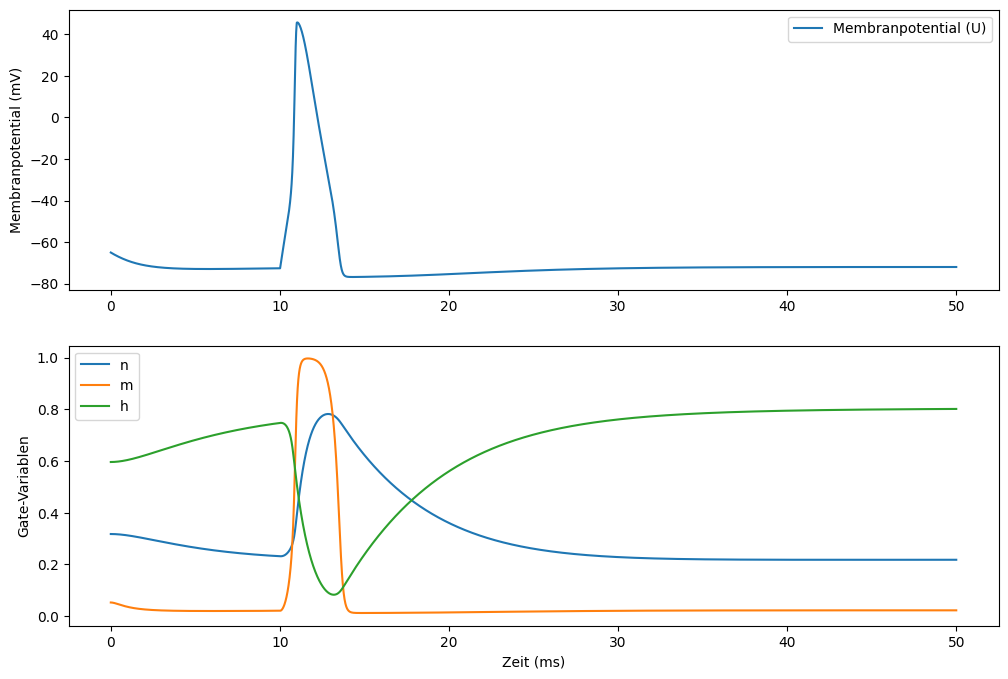

In [13]:
I_0 = -5
I_pulse = 50

def I_ext_pulse(t):
    return I_pulse if 10 < t < 11 else I_0

t, U, n, m, h = HHSimulationClassicalRungeKutta(hh_model, time=50, dt=0.01, I_ext=I_ext_pulse).run()

HHSimulation.plot_results(t, U, n, m, h)

Die Gatingvariablen bestimmen die Dynamik der Spannung und die Aktivierung der Ionenkanäle:
- m: Ein hoher m-Wert korreliert mit einem Spannungsausschlag. m kehrt schneller als n und h wieder zurück zum Gleichgewichtszustand.
- n: Ein hoher n-Wert zeigt die Aktivierung des Kalium Kanals.
- h: Ein hoher h-Wert zeigt die Bereitschaft des Kanals aktiviert zu werden. Nach der Aktivierung ist h niedrig und muss erst während der Refraktärzeit wieder ansteigen, bis es zu einer erneuten Aktivierung kommen kann.